In [26]:
# takes multiple csv files containing SPAT messages as an input from folder called input.
# and gives 'seq_G2R_output.csv' as output file in the Output folder
# the output file contains a ranking of every signal group of the input
# and its performance data based on green to red predictions

# these libraries are necessary
import pandas as pd
import numpy as np
import warnings
from tqdm import tqdm
import glob
import os


warnings.filterwarnings('ignore')

# get current path
# path = os.path.dirname(os.path.realpath(__file__)) + "/" + "input"

print('Reading all .csv files, this can take a while...')

# get all csv files in current path
# all_files = glob.glob(os.path.join(path, "*.csv"))

# # concatenate all data and load as dataframe
# df_from_each_file = (pd.read_csv(f) for f in tqdm(all_files))
# df = pd.concat(df_from_each_file, ignore_index=True)

df = pd.read_csv('input/data_sorted.csv')

# filtering out useless data
df = df[df.state != 'unavailable']
df = df[df.state != 'caution-Conflicting-Traffic']

# convert to datetime format
df['received_timestamp'] = pd.to_datetime(df['received_timestamp'], unit='ms')
df['state_timestamp'] = pd.to_datetime(df['state_timestamp'], unit='ms')
df['state_end_min'] = pd.to_datetime(df['state_end_min'], unit='ms')
df['state_end_max'] = pd.to_datetime(df['state_end_max'], unit='ms')
df['state_end_likely'] = pd.to_datetime(df['state_end_likely'], unit='ms')
df = df.sort_values(by="state_timestamp")
df = df.drop_duplicates()

# grouping of signalgroups
signalgroups = [d for _, d in df.groupby('id')]

# resetting index
signalgroups = [d.reset_index() for d in signalgroups]


# tijd function makes a new column containing the timestamp of the next sequence change
def tijd(signalgroup):

    # make dataframe with a new interval each row
    df1 = signalgroup.loc[(signalgroup.ischanged == True)]

    # create real time column and fill timestamps inbetween
    df1['time_s'] = np.nan
    df1["time_shift"] = df1["state_timestamp"].shift(-1).replace()
    signalgroup['time_s'] = np.nan
    signalgroup.loc[df1.index,'time_s'] = df1['time_shift']
    signalgroup['time_s'] = signalgroup['time_s'].fillna(method='ffill')
    signalgroup['time_s'] = pd.to_datetime(signalgroup['time_s'])

    # check that the sequence time is not later than the state timestamp
    signalgroup['difference'] = (signalgroup['time_s'] - signalgroup['state_timestamp']).dt.total_seconds()
    signalgroup.drop(signalgroup[signalgroup.difference < 0].index, inplace=True)
    signalgroup.drop('difference', axis = 1, inplace=True)
    return signalgroup

print()
print("Preparing DataFrames...")
# creating dataframes per signalgroup
signals = ['permissive-clearance',
           'caution-Conflicting-Traffic',
           'protected-Movement-Allowed',
           'permissive-Movement-Allowed',
           'pre-Movement',
           'protected-clearance']

id_list = []
groups = []
minmaxgroups = []
for signalgroup in tqdm(signalgroups):
    # make a list with all signal group IDs for later use
    id_list.append(signalgroup['id'].to_list()[0])

    # change all state values to "green" and "red"
    signalgroup['state'] = np.where(signalgroup['state'].isin(signals), "green", "red")

    # shift the states to search for sequences
    signalgroup["ischanged"] = signalgroup[
                                   "state"
                               ].shift(1, fill_value=signalgroup["state"].head(1)) != signalgroup["state"]

    # put every signalgroup through the tijd() function
    signalgroup = tijd(signalgroup)
    minmax = signalgroup
    minmaxgroups.append(minmax)

    # drop all row with no state_end_likely and create column indicating new sequence
    signalgroup = signalgroup.dropna(subset=['state_end_likely'])
    signalgroup["new_sequence"] = signalgroup["time_s"].shift(1) != signalgroup["time_s"]
    groups.append(signalgroup)


#resetting index
groups = [d.reset_index() for d in groups]

# adding weights to the timestamp
def weights(group):
    # create arrays for weights
    group['weights'] = group['weights'].fillna(0)
    vector = group['weights'].to_numpy()
    indeces = group.index[group['new_sequence'] == True].tolist()

    # check if there are sequences
    if len(indeces) == 0:
        return group

    # remove the first indecece if 0
    if indeces[0] == 0:
        indeces = np.delete(indeces, 0)

    # split the weights per sequence
    sequences = np.split(vector, indeces, axis=0)
    weights = []

    # normalize weights per sequence
    for seq in sequences:
        n = seq/seq.sum()
        weights.append(n)

    # add weights to dataframe
    weights = np.array(weights)
    weights = np.concatenate(weights).ravel()
    group['weights'] = weights

    return group

# initiate columns
errors = {}
stds = {}
means = {}
nums = {}
seq = {}
maxaccs = {}
minaccs = {}


# choose here what state combo you would like. red to green, green to red, or both
for i in range(len(groups)):
    group = groups[i]
    mmgroup = minmaxgroups[i]
    groups[i] = group[group['state'] == 'red']
    minmaxgroups[i] = mmgroup[mmgroup['state'] == 'red']


print()
print("Ranking data")
# Calculate difference and error
for i, signal in tqdm(enumerate(groups), total=len(groups)):

    # check if signal has predictions
    if len(signal.index) < 1:
        error = float('inf')
        signal_id = id_list[i]
        errors[signal_id] = error
        standard_D = float('inf')
        stds[signal_id] = standard_D
        means[signal_id] = float('inf')
        nums[signal_id] = 0
        maxaccs[signal_id] = 0
        minaccs[signal_id] = 0
    else:
        # difference time, switch time.
        signal["weights"] = signal['time_s'] - signal['state_timestamp']
        signal['weights'] = (abs(signal["weights"].dt.total_seconds()))
        signal.drop(signal[signal.weights > 300].index, inplace=True)
        signal["weights"] =  1/ signal["weights"]

        # update weights
        signal = weights(signal)

        # difference pred, real
        signal["difference"] = (signal['time_s'] - signal['state_end_likely'])
        signal["difference"] = signal["difference"].dt.total_seconds() * signal["weights"]
        signal.drop(signal[abs(signal.difference) > 3000].index, inplace=True)

        #number of sequences used
        signal_id = signal['id'].to_list()[0]
        seq[signal_id] = (signal.new_sequence).sum()

        #compute error
        arr = signal["difference"] **2
        error = arr.sum()/seq[signal_id]
        errors[signal_id] = error

        # standard deviation of difference
        standard_D = signal['difference'].std()
        stds[signal_id] = standard_D

        # mean of difference
        means[signal_id] = signal['difference'].mean()

        # number of messages used
        nums[signal_id] = len(signal['difference'])



        # calculate the amount of min and max predictions that were true
        df = minmaxgroups[i].dropna(subset=['state_end_min'])
        if len(df.index)<1:
            minaccs[signal_id] = 0
        else:
            df['min'] = (df['state_end_min'] <= df['time_s'])
            minaccs[signal_id] = df['min'].value_counts()[True]/len(df.index)
        df = minmaxgroups[i].dropna(subset=['state_end_max'])
        if len(df.index)<1:
            maxaccs[signal_id] = 0
        else:
            df['max'] = (df['state_end_max'] >= df['time_s'])
            maxaccs[signal_id] = df['max'].value_counts()[True]/len(df.index)

# ranking
ranked = dict(sorted(errors.items(), key=lambda item: item[1]))

# final dataframe with outputs
outputdf = pd.DataFrame.from_dict(ranked, orient='index', columns=['MSE'])
outputdf["STD diff"] = pd.Series(stds)
outputdf["Mean diff"] = pd.Series(means)
# make a column of maximum error of a 'good' prediction using the mean and std of difference
outputdf["Benchmark"] = abs(outputdf["Mean diff"])+2*outputdf["STD diff"]
outputdf["NumPred"] = pd.Series(nums)
outputdf["NumSeq"] = pd.Series(seq)
outputdf["MaxAcc"] = pd.Series(maxaccs)
outputdf["MinAcc"] = pd.Series(minaccs)
# compute the final score by using the min and max accuracies as weights
outputdf.insert(0, 'Score', outputdf['MSE']/outputdf['MaxAcc']/outputdf['MinAcc'])
outputdf = outputdf.sort_values('Score')

# data to csv
folderName = 'output'
if not os.path.exists(os.getcwd() + '/' + folderName):
    os.makedirs(os.getcwd() + '/' + folderName, exist_ok=True)

outputdf.to_csv('output/R2G_output.csv')

print("Done")

Reading all .csv files, this can take a while...

Preparing DataFrames...


100%|██████████| 264/264 [00:56<00:00,  4.66it/s]



Ranking data


100%|██████████| 264/264 [00:09<00:00, 28.07it/s]

Done


In [27]:
# Splits region ID up into junction level
regiondf = pd.DataFrame()
regiondf = outputdf.index.str.split('-', expand=True)
jnct_id = []
for firstval in range(len(regiondf)):
    for secondval in range(0,1):
        x = regiondf[firstval][secondval]
        y = regiondf[firstval][secondval+1]
        junction = x + y
        jnct_id.append(junction)

traffic_light_id = []
for firstval in range(len(regiondf)):
    x = regiondf[firstval][-1]
    traffic_light_id.append(x)

outputdf['traffic_light_id']=traffic_light_id
outputdf_2 = outputdf
outputdf['jnct_id']=jnct_id

In [28]:
cluster_df = outputdf
cluster_df = cluster_df.replace([np.inf, -np.inf], np.nan).dropna()
cluster_df

,Score,MSE,STD diff,Mean diff,Benchmark,NumPred,NumSeq,MaxAcc,MinAcc,traffic_light_id,jnct_id
2041380874-31149-11-2,0.002876,0.001748,0.007819,-0.000509,0.016148,26217,921.0,1.000000,0.607636,2,204138087431149
2041380874-31149-11-1,0.047914,0.029912,0.032196,-0.002006,0.066397,27079,942.0,1.000000,0.624282,1,204138087431149
2057699418-31398-91-1,0.126610,0.121510,0.102619,-0.008931,0.214169,356,31.0,1.000000,0.959716,1,205769941831398
2057699438-31398-111-13,0.176774,0.155290,0.076717,-0.024721,0.178155,1465,61.0,0.994969,0.882907,13,205769943831398
2057699388-31398-61-12,0.196445,0.165200,0.085961,-0.022058,0.193980,1711,79.0,0.964497,0.871903,12,205769938831398
...,...,...,...,...,...,...,...,...,...,...,...
2032927010-31020-291-16,476907.825279,167118.754503,83.561485,-11.816513,178.939482,5980,254.0,0.374855,0.934819,16,203292701031020
2032927010-31020-291-17,510293.860519,124132.565646,114.744743,-18.628695,248.118181,1306,140.0,0.442573,0.549643,17,203292701031020
2032927010-31020-291-5,598436.612141,199948.341521,82.632884,-11.219725,176.485492,24299,845.0,0.414050,0.806951,5,203292701031020
2057044078-31388-111-6,638722.191103,422459.721721,57.531833,-4.028993,119.092659,118139,930.0,0.694589,0.952238,6,205704407831388


### Import Libraries for Clustering

In [29]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import plotly.express as px

### Create Instance Of The Scaler
First create an instance of the scaler that we will use to transform the data

In [30]:
scaler = StandardScaler()

### Scale The Data In The Dataframe
For the clustering we will use the 'SCORE, 'MSE', 'STD diff', 'Benchmark', 'NumPred', 'NumSeq', 'MinAcc' and 'MinAcc'. So we create new colums for the transformed data.

In [31]:
cluster_df[['Score_T', 'MSE_T', 'STD diff_T', 'Benchmark_T', 'NumSeq_T', 'MaxAcc_T', 'MinAcc_T']] = scaler.fit_transform(cluster_df[['Score','MSE', 'STD diff', 'Benchmark', 'NumSeq', 'MaxAcc', 'MinAcc']])

In [32]:
cluster_df

,Score,MSE,STD diff,Mean diff,Benchmark,NumPred,NumSeq,MaxAcc,MinAcc,traffic_light_id,jnct_id,Score_T,MSE_T,STD diff_T,Benchmark_T,NumSeq_T,MaxAcc_T,MinAcc_T
2041380874-31149-11-2,0.002876,0.001748,0.007819,-0.000509,0.016148,26217,921.0,1.000000,0.607636,2,204138087431149,-0.703573,-0.701418,-0.744471,-0.726332,0.665520,0.912123,-2.308480
2041380874-31149-11-1,0.047914,0.029912,0.032196,-0.002006,0.066397,27079,942.0,1.000000,0.624282,1,204138087431149,-0.703573,-0.701417,-0.743733,-0.725627,0.713742,0.912123,-2.157094
2057699418-31398-91-1,0.126610,0.121510,0.102619,-0.008931,0.214169,356,31.0,1.000000,0.959716,1,205769941831398,-0.703572,-0.701416,-0.741601,-0.723556,-1.378189,0.912123,0.893586
2057699438-31398-111-13,0.176774,0.155290,0.076717,-0.024721,0.178155,1465,61.0,0.994969,0.882907,13,205769943831398,-0.703572,-0.701416,-0.742385,-0.724061,-1.309300,0.882813,0.195035
2057699388-31398-61-12,0.196445,0.165200,0.085961,-0.022058,0.193980,1711,79.0,0.964497,0.871903,12,205769938831398,-0.703572,-0.701416,-0.742105,-0.723839,-1.267967,0.705304,0.094955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2032927010-31020-291-16,476907.825279,167118.754503,83.561485,-11.816513,178.939482,5980,254.0,0.374855,0.934819,16,203292701031020,2.341188,1.247078,1.784607,1.781754,-0.866114,-2.729613,0.667159
2032927010-31020-291-17,510293.860519,124132.565646,114.744743,-18.628695,248.118181,1306,140.0,0.442573,0.549643,17,203292701031020,2.554338,0.745887,2.728491,2.751477,-1.127893,-2.335128,-2.835911
2032927010-31020-291-5,598436.612141,199948.341521,82.632884,-11.219725,176.485492,24299,845.0,0.414050,0.806951,5,203292701031020,3.117075,1.629849,1.756500,1.747355,0.491001,-2.501285,-0.495771
2057044078-31388-111-6,638722.191103,422459.721721,57.531833,-4.028993,119.092659,118139,930.0,0.694589,0.952238,6,205704407831388,3.374273,4.224187,0.996718,0.942842,0.686186,-0.867028,0.825582


### Identifying The Optimum Amount of Clusters

To identify the optimum amount of clusters we use something called the elbow method. We plot the amount of inertia against the number of clusters. So we see at what point an increased amount of clusters stops providing extra information. You can read this from the graph by seeing when the curve flattens. Here it is around 2/3.

In [33]:
def optimise_k_means(data, max_k):
    means = []
    inertias = []

    for k in range(1, max_k):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        means.append(k)
        inertias.append(kmeans.inertia_)

    fig = plt.subplots(figsize=(10, 5))
    plt.plot(means, inertias, 'o-')
    plt.xlabel("Number of Clusters")
    plt.ylabel("Inertia")
    plt.grid(True)
    plt.show()

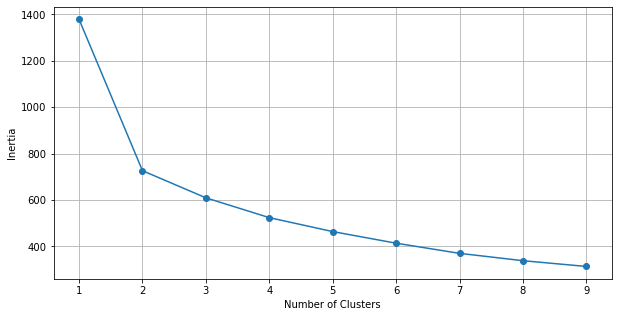

In [34]:
optimise_k_means(cluster_df[['Score_T', 'MSE_T', 'STD diff_T', 'Benchmark_T', 'NumSeq_T', 'MaxAcc_T', 'MinAcc_T']], 10)

We chose K=2.

#### Fit the clustering model for 2 clusters

In [35]:
kmeans = KMeans(n_clusters=2)

In [36]:
kmeans.fit(cluster_df[['Score_T', 'MSE_T', 'STD diff_T', 'Benchmark_T', 'NumSeq_T', 'MinAcc_T', 'MinAcc_T']])

KMeans(n_clusters=2)

#### Add cluster catagory to the dataframe

In [37]:
cluster_df['K_means_2'] = kmeans.labels_

In [38]:
cluster_df

,Score,MSE,STD diff,Mean diff,Benchmark,NumPred,NumSeq,MaxAcc,MinAcc,traffic_light_id,jnct_id,Score_T,MSE_T,STD diff_T,Benchmark_T,NumSeq_T,MaxAcc_T,MinAcc_T,K_means_2
2041380874-31149-11-2,0.002876,0.001748,0.007819,-0.000509,0.016148,26217,921.0,1.000000,0.607636,2,204138087431149,-0.703573,-0.701418,-0.744471,-0.726332,0.665520,0.912123,-2.308480,1
2041380874-31149-11-1,0.047914,0.029912,0.032196,-0.002006,0.066397,27079,942.0,1.000000,0.624282,1,204138087431149,-0.703573,-0.701417,-0.743733,-0.725627,0.713742,0.912123,-2.157094,1
2057699418-31398-91-1,0.126610,0.121510,0.102619,-0.008931,0.214169,356,31.0,1.000000,0.959716,1,205769941831398,-0.703572,-0.701416,-0.741601,-0.723556,-1.378189,0.912123,0.893586,1
2057699438-31398-111-13,0.176774,0.155290,0.076717,-0.024721,0.178155,1465,61.0,0.994969,0.882907,13,205769943831398,-0.703572,-0.701416,-0.742385,-0.724061,-1.309300,0.882813,0.195035,1
2057699388-31398-61-12,0.196445,0.165200,0.085961,-0.022058,0.193980,1711,79.0,0.964497,0.871903,12,205769938831398,-0.703572,-0.701416,-0.742105,-0.723839,-1.267967,0.705304,0.094955,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2032927010-31020-291-16,476907.825279,167118.754503,83.561485,-11.816513,178.939482,5980,254.0,0.374855,0.934819,16,203292701031020,2.341188,1.247078,1.784607,1.781754,-0.866114,-2.729613,0.667159,0
2032927010-31020-291-17,510293.860519,124132.565646,114.744743,-18.628695,248.118181,1306,140.0,0.442573,0.549643,17,203292701031020,2.554338,0.745887,2.728491,2.751477,-1.127893,-2.335128,-2.835911,0
2032927010-31020-291-5,598436.612141,199948.341521,82.632884,-11.219725,176.485492,24299,845.0,0.414050,0.806951,5,203292701031020,3.117075,1.629849,1.756500,1.747355,0.491001,-2.501285,-0.495771,0
2057044078-31388-111-6,638722.191103,422459.721721,57.531833,-4.028993,119.092659,118139,930.0,0.694589,0.952238,6,205704407831388,3.374273,4.224187,0.996718,0.942842,0.686186,-0.867028,0.825582,0


### Plot the Score against the Junction ID's, also including what cluster each point belongs to

In [57]:
fig = px.scatter(cluster_df,
                 x = cluster_df['jnct_id'],
                 y = cluster_df['Score'],
                 color = cluster_df['K_means_2'],
                 hover_name = cluster_df.index,
                 size = cluster_df['NumSeq'],
                 color_continuous_scale=px.colors.sequential.Peach
                 )

fig.show()